# Step 5: Plots and diagnostics

In this notebook we will:
- Plot the forecast
- Look at the feature importance of the model 

In [1]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd

from sklearn import set_config
set_config(transform_output="pandas")

# Config paths

Specify the paths and directories from which we will read and write data to. In practice we would store this in a separate file rather than duplicate it across all notebooks. For simplicity, we specify the paths in the notebook itself.

In [2]:
# Artifacts directory for storing the
# training data, models, pipelines etc.
artifacts_dir = Path("../artifacts")
training_dir = artifacts_dir / "training"
pipeline_dir = artifacts_dir / "pipeline"
model_dir = artifacts_dir / "model"
plots_dir = artifacts_dir / "plots"
forecast_dir = artifacts_dir / "forecast"

# Create directories
plots_dir.mkdir(exist_ok=True)

# Load forecast, model, features, and in-sample predictions

In [3]:
f_in = forecast_dir / "predict_dataset.parquet"
df_predict = pd.read_parquet(f_in)

In [4]:
f_in = training_dir / "data.parquet"
df_train = pd.read_parquet(f_in)
y_train = df_train.loc[:, ["y"]]
X_train = df_train.drop(columns=["y"])

In [5]:
f_in = model_dir / "model.joblib"
model = joblib.load(f_in)

In [6]:
f_in = forecast_dir / "in_sample_predictions.parquet"
df_insample = pd.read_parquet(f_in)

# Plot forecasts

## Plot in-sample predictions

In [7]:
n_series = 12
np.random.seed(0)
ts_ids = np.random.choice(df_insample.index.levels[0].values, size=n_series, replace=False)

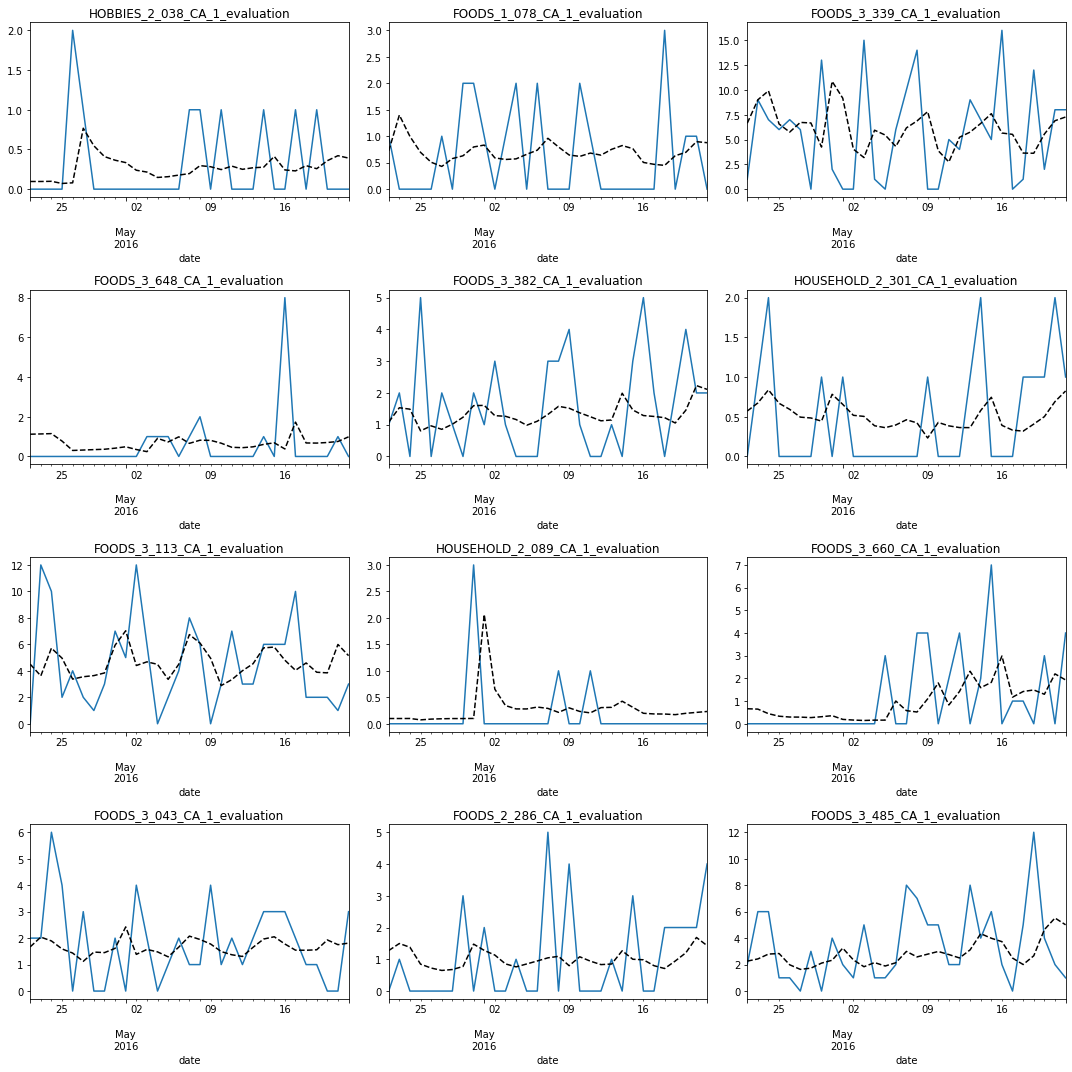

In [8]:
# Plot subset of forecasts
n_series = 12
fig, ax = plt.subplots(nrows=n_series // 3, ncols=3, figsize=[15, 15])
for ix, ax in enumerate(ax.flatten()):
    ts_id = ts_ids[ix]
    # Plot actuals
    df_insample.loc[ts_id, "y"].plot(ax=ax)
    # Plot forecasts
    df_insample.loc[ts_id, "y_pred"].plot(
        ax=ax, linestyle="--", color="k"
    )
    ax.set_title(ts_id)
plt.tight_layout()
plt.show()

## Plot a random sample of the time series.

In [9]:
n_series = 12
np.random.seed(0)
ts_ids = np.random.choice(df_predict.index.levels[0].values, size=n_series, replace=False)

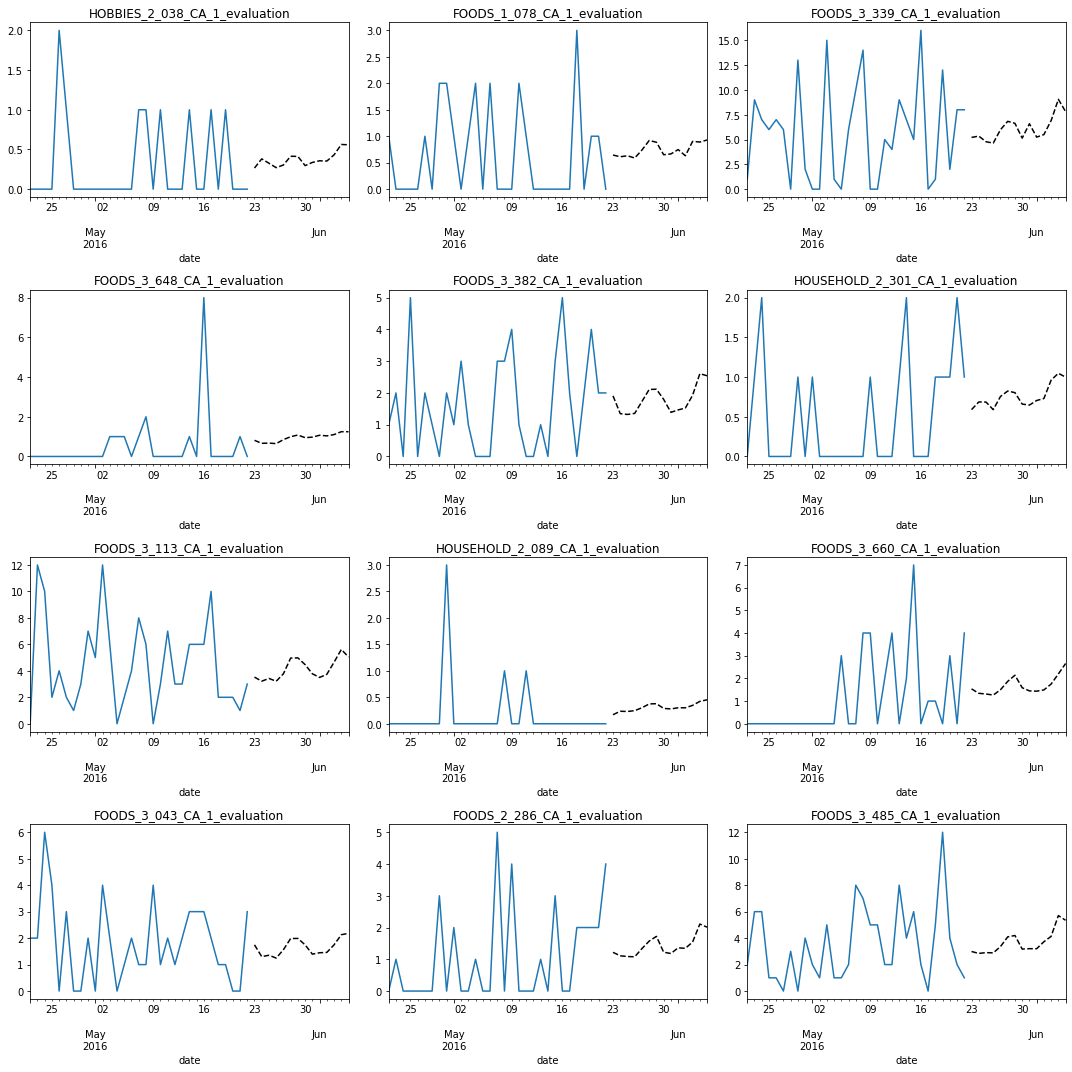

In [10]:
# Plot subset of forecasts
n_series = 12
fig, ax = plt.subplots(nrows=n_series // 3, ncols=3, figsize=[15, 15])
for ix, ax in enumerate(ax.flatten()):
    ts_id = ts_ids[ix]
    # Plot actuals
    df_predict.query("is_forecast==False").loc[ts_id, "y"].plot(ax=ax)
    # Plot forecasts
    df_predict.query("is_forecast==True").loc[ts_id, "y"].plot(
        ax=ax, linestyle="--", color="k"
    )
    ax.set_title(ts_id)
plt.tight_layout()
plt.show()

## Plot aggregated forecast

In [11]:
actuals_agg = df_predict.query("is_forecast==False")["y"].groupby(level=-1).sum()
forecast_agg = df_predict.query("is_forecast==True")["y"].groupby(level=-1).sum()

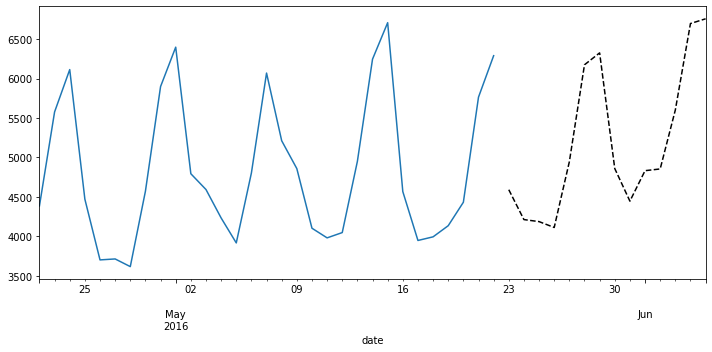

In [12]:
fig, ax = plt.subplots(figsize=[10, 5])

# Plot aggregate actuals
actuals_agg.plot(ax=ax)
forecast_agg.plot(ax=ax, linestyle="--", color="k")

plt.tight_layout()
plt.show()

# Feature importance

In [13]:
model = joblib.load(model_dir / "model.joblib")

## LightGBM feature importance

In [14]:
from lightgbm import plot_importance

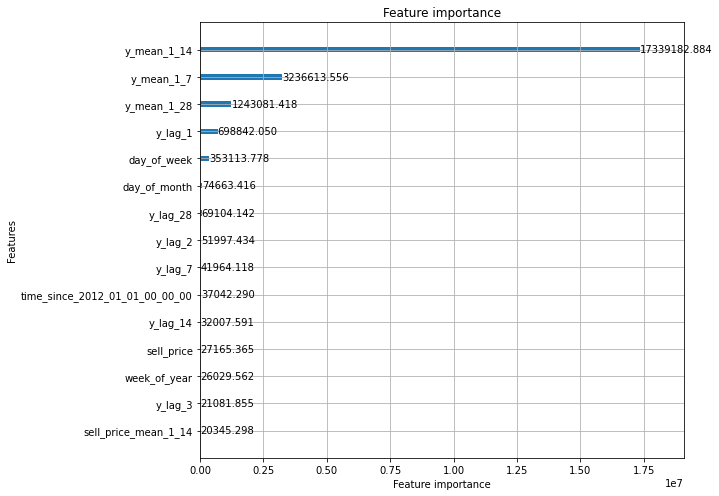

In [15]:
# Plot gain feature importance
fig, ax = plt.subplots(figsize=(10, 7))
ax = plot_importance(
    model, importance_type="gain", max_num_features=15, ax=ax,
)

plt.tight_layout()
f_out = plots_dir / "feat_importance_gain.png"
fig.savefig(f_out)

## SHAP

In [16]:
import shap

Let's randomly sample a % of datapoints from each time series to use with SHAP.

In [17]:
X_shap = X_train.groupby(level=0).apply(lambda x: x.sample(frac=0.05)).droplevel(0)

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

Save the X_shap dataframe and calculated shap values.

In [19]:
f_out = plots_dir / "X_shap.parquet"
X_shap.to_parquet(f_out)

f_out = plots_dir / "shap_values.parquet"
pd.DataFrame(shap_values, columns=X_shap.columns).to_parquet(f_out)

Note: LightGBM can natively produce shap values using `pred_contrib=True`. 

So we could also have done the following to obtain the shap values:

```Python
shap_values = model.predict(X_shap, pred_contrib=True)
```

Let's plot the feature importances.

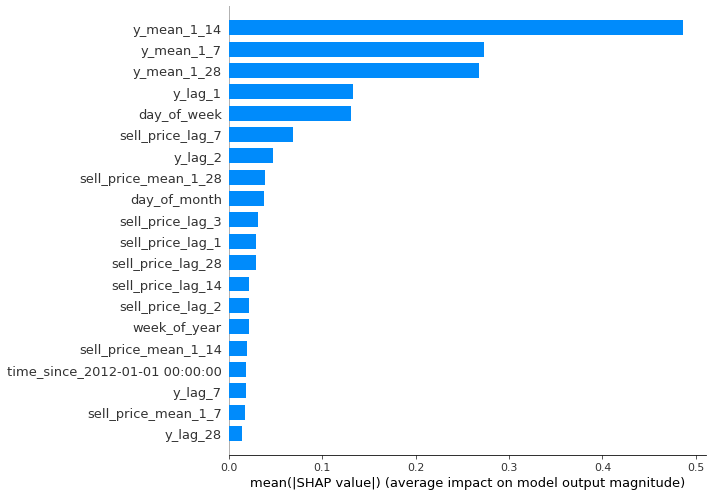

In [20]:
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X_train.columns,
    plot_type="bar",
    max_display=20,
    plot_size=(10, 7),
    show=False
)

fig = plt.gcf()
plt.tight_layout()
f_out = plots_dir / "feat_importance_shap.png"
fig.savefig(f_out)